In [ ]:
import xlwt
import re
import urllib.request, urllib.error
from bs4 import BeautifulSoup
import csv
import pandas as pd
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()
import string
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Using Bs4 to find the review we need out of the source code of the websites
def findReview(baseurl):
    datalist = []
    for i in range(1,11):
        print(i)
        url = baseurl + str(i)
        html = askURL(url)
        soup = BeautifulSoup(html, "html.parser")
        data = []
        for item in soup.find_all("div", class_="text show-more__control"):
            item = str(item)
            item = item[37:len(item)-6]
            print(item)
            data.append(item)
            

        
        datalist.append(data)
    

    return datalist

In [ ]:
# fetch the content of the url and decode it
def askURL(url):
  
    #You might need to change the head according to your explorer
    head = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36"}
    res = urllib.request.Request(url=url, headers=head)

    try:
        response = urllib.request.urlopen(res)

        html = response.read().decode("utf-8")
        # print(html)
        return html
    except urllib.error.URLError as e:

        if hasattr(e, "code"):
            print(e.code)
        if hasattr(e, "reason"):
            print(e.reason)

In [ ]:
# This function writes the texts we stored in datalist to an excel sheet
def writeandread(datalist,savepath):
    workbook = xlwt.Workbook(encoding="utf-8")  # initiate a workbook subject
    worksheet = workbook.add_sheet('ScoreList')
    # for i in range(0, 10):
    #     worksheet.write(0, "Score")

    for j in range(0, 10):
        data = datalist[j]
        print("%d" %(j+1))
        for k in range(0, len(data)):
            worksheet.write(j + 1, k, data[k])

        workbook.save(savepath)

In [ ]:
#prepare stopword filter
nltk.download('stopwords') 
stopword_list = nltk.corpus.stopwords.words('english') 

print(string.punctuation)
stopword_list.extend(string.punctuation)

custom_stop_list = ['br','"','I', '"'"''", "``", 'Little','little','And','every','Every','``','--', 'My','you','You','\'s' ,'it', 'It','said','One','one','She','would','Would','But', 'They', 'The','the','He','','The', '.\"']
stopword_list.extend(custom_stop_list)
print(stopword_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where'

In [ ]:
# Combine every texts under each score together into one string for tokenization, and store the strings into a new list.
def combine(datalist):
  newlist = []
  for data in datalist:
    a = ""
    for i in data:
      a = a+" "+i
      
    newlist.append(a)
    
  return newlist
    

# tokenize the texts into sentences
def clean(newlist):
  tokenized_list = []
  tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
  for item in newlist:
    tokenized_item = tokenizer.tokenize(item)
    

    tokenized_list.append(tokenized_item)
  a = tokenized_list[0]
  for num, sentence in enumerate(a[:20]):
    print(num, sentence)     
  return tokenized_list
  



# tokenized the texts into words
def clean2(newlist):
  tokenized_text = [nltk.wordpunct_tokenize(segment) for segment in newlist] 
  clean_text = [] # create an empty list to receive the cleaned-up tokens
  i = 0
  for wordlist in tokenized_text:
    clean_wordlist = []
    for word in wordlist:
        if word not in stopword_list and word.isalpha(): # clear out punctuation and stopwords
            clean_wordlist.append(word.lower()) # cast words in lower case
    clean_text.append({'rating number':i+1,'Word list':clean_wordlist})
    i = i+1
  print(clean_text[0])
  return clean_text



In [ ]:
def emo_calculator(c):
  sum_scorelist = []   
  i=0
  for score in c:
      emo_val = 0
      for sentence in score:
        emo_val += sentiment_analyzer.polarity_scores(sentence)['compound']
      # sum_scorelist.append({'Score %d'%i:emo_val})
      emo_val = emo_val/(len(score))
      print(emo_val)
      sum_scorelist.append({'score_number': i+1, 'sentiment_score': emo_val})  
      i = i+1
      print(i)

  sum_score_df = pd.DataFrame(sum_scorelist)
  sum_score_df.plot(x='score_number', y='sentiment_score', kind='bar', title = 'mean of emotional valance for each rating')  
  sum_score_df.plot(x='score_number', y='sentiment_score', kind='line', title = 'mean of emotional valance for each rating')

  

   
     
  

In [ ]:
# fetch the user review we want and store it into an excel sheet if u want:)

baseurl = "https://www.imdb.com/title/tt0362227/reviews?sort=helpfulnessScore&dir=desc&ratingFilter="

savepath = input("What is the savepath you wanna have")
    
datalist = findReview(baseurl)

writeandread(datalist,savepath)


    

   
  

In [ ]:
com_list = combine(datalist)

newlist = clean(com_list)

emo_calculator(newlist)

In [ ]:
token_list = clean2(com_list)

# it would be better to create a list instead of using the dict

new_token_list = []
for i in token_list:
  new_token_list.append(i['Word list'])

print(new_token_list[0])



freq_list = [nltk.FreqDist(segment) for segment in new_token_list]
print(len(freq_list))

most_common = [segment.most_common(10) for segment in freq_list]  

print(most_common[:18])

for i in freq_list:
  i.plot(30,cumulative=False)
  



In [ ]:
# maybe find the frequency distribtion of a specific word?
def word_dist(new_token_list):
  a = input('What is the word you wanna know?')
  word_counts = [nltk.FreqDist(segment)[a] for segment in new_token_list]
  plt.plot(word_counts)

word_dist(new_token_list)



What is the savepath you wanna have/
1
Maybe I missed something in this movie, but I thought it was one of the worst movies I have seen in quite some time. At least for adults. True, there were a few cute jokes, but how many jokes can be done at the expense of the panda being fat and flabby before the audience, even children, say Okay, we got it. The theater was about 2/3 full and for most of this movie people were getting up to leave; adults and children. A man a few seats down was snoring, which was one of the more entertaining aspects of this movie. Some of the dialogue was muddled and some of the action so fast it was hard to keep up and not get a headache. It had a nice basic plot, which was okay, but there were aspects of this movie that were not fully developed, and this included character development. For example, when Po asks his dad if he's really his dad (since the dad was a duck). I would have liked to see more development of the main characters, other than Hoffman's, as th

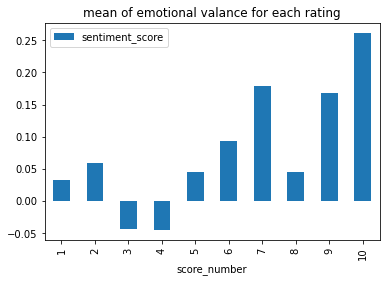

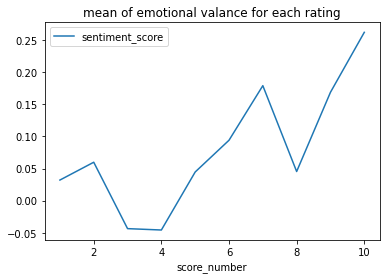

In [ ]:
# now maybe try a different movie?
# here is the baseurl for user reviews of Kung Fu panda: https://www.imdb.com/title/tt0441773/reviews?sort=helpfulnessScore&dir=desc&ratingFilter=1
baseurl = 'https://www.imdb.com/title/tt0441773/reviews?sort=helpfulnessScore&dir=desc&ratingFilter='

savepath = input("What is the savepath you wanna have")
    
datalist = findReview(baseurl)

# writeandread(datalist,savepath)

com_list = combine(datalist)

newlist = clean(com_list)

emo_calculator(newlist)

print("Seems like it also works")
